# Datashader Workshop

`Datashader` is a graphics pipeline system for visualizing large amounts of data. It breaks the creation of images into 3 steps:
1. Projection: Each record is projected into zero or more bins.
2. Aggregation: Reductions are computed for each bin, compressing the datset into a smaller aggregate one.
3. Transformation: Aggregates are further processed to create an image.

The `Datashader` module from Continuum Analytics came out of funding from DARPA’s XDATA program, a research effort to develop new computational techniques and open-source software tools for processing and analyzing big data.

Import Python modules.  
- Standard Python modules.
- `Bokeh` modules.
- `Datashader` modules.

In [1]:
%%time
import pandas as pd
import numpy as np

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import WMTSTileSource

import datashader as ds
import datashader.transfer_functions as tf
from datashader.callbacks import InteractiveImage

output_notebook()
%matplotlib inline

ImportError: No module named 'datashader.callbacks'

In [2]:
pd.options.display.max_rows = 10

## Read Data

In [3]:
%time df = pd.read_csv('data/testset.csv', usecols = [0,1,3,7,8,10,11,15], header=0)
#%time df = pd.read_csv('data/bsm41993-41994.csv', header=0, usecols=[0,1,3,4,5,7,8,12,13])
#df = df.iloc[::10,:]
#df = df.query('TripStart == 41994')
df.tail()

Wall time: 20.2 s


,RxDevice,FileId,Gentime,Latitude,Longitude,Speed,Heading,Yawrate
10054440,3099,9210160,354639197757058,42.220291,-83.761009,12.72,244.35001,-1.72
10054441,3099,9210160,354639197857067,42.220284,-83.761024,12.68,244.37500,-0.94
10054442,3099,9210160,354639197957066,42.220280,-83.761040,12.50,243.71249,-1.66
10054443,3099,9210160,354639198057042,42.220276,-83.761055,12.52,244.41251,-0.33
10054444,3099,9210160,354639198157022,42.220268,-83.761070,12.36,243.83749,-0.73


In [4]:
df.shape

(10054445, 8)

In [5]:
#dfc = df.copy()

## Some Data Wrangling

Function to convert _latitude_, _longitude_ degree coordinates to meters in web mercator projection.

In [6]:
def latlng_to_meters(df, lat_name, lng_name):
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = df[lng_name] * origin_shift / 180.0
    my = np.log(np.tan((90 + df[lat_name]) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    mx = mx.apply(lambda x: np.around(x,0))
    my = my.apply(lambda y: np.around(y,0))
    df.loc[:,lng_name] = mx.astype(int)
    df.loc[:,lat_name] = my.astype(int)
    return df

Call `latlng_to_meters` conversion function.  
Convert _Speed_ to mph.  
Make _Gentime_ as small as possible.  
Rename columns.  
Discard data containing speeds above 100 _mph_.  

In [7]:
df = latlng_to_meters(df,"Latitude","Longitude")
df['Speed'] = df['Speed']*2.23694
df['Gentime'] = df['Gentime'] - df['Gentime'].min()
df.rename(columns={'Latitude':'y','Longitude':'x','Speed':'mph'}, inplace=True)
df = df.query('mph < 100')

Take absolute value of _Yawrate_.
Discard data containing rates above 28 deg/s.

In [8]:
df["Yawrate"] = abs(df["Yawrate"])
df = df.query('Yawrate < 28')

Bin _Heading_ data into one of the 4 directions using trignometric and sign transforms.

In [9]:
sinHead = 2*np.sign(np.sin(df.Heading * np.pi / 180 + np.pi/4))
cosHead = np.sign(np.cos(df.Heading * np.pi / 180 + np.pi/4))
df["Direction"] = sinHead + cosHead

## Standard Bokeh Plot

Manually set xy range of figure

In [10]:
if False:
    xrange = [x-1000 for x in (-9324094,-9314310)]
    yrange = [y+1500 for y in (5195271, 5205055)]
else:
    xrange = [x+2000 for x in (-9333878,-9314310)]
    yrange = [y+6000 for y in (5185487, 5205055)]

Define our basic `Bokeh` plot configuration. Set interactive tools, xy range, plot width and height.  
Set axis and grid lines to off.  
Define border margins.

In [11]:
width = 400
height = 400
def base_plot():
    p = figure(tools='pan, box_zoom, reset', plot_width=width, plot_height=height,
              x_range=xrange, y_range=yrange, outline_line_color=None)
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.min_border_bottom = 0
    p.min_border_top = 0
    p.min_border_left = 0
    p.min_border_right = 0
    return p

Draw `Bokeh` figure using `circle` markers.

In [12]:
options = dict(line_color=None, fill_color='blue', size=3, alpha=0.1)
samples = df.sample(n=10000, random_state=20160)
s = base_plot()
s.circle(samples['x'], samples["y"], **options)
show(s)

## Datashader Plot

Create a canvas representing the space for binning data records.  
**Projection and Aggregation Step**: Create points centered at x and y with the z-value being the aggregate summary (count in this case).  
**Transformation Step**: Converts the 2D DataArray (pts) to an image interpolating between the low and high color linearly.  
Display the image

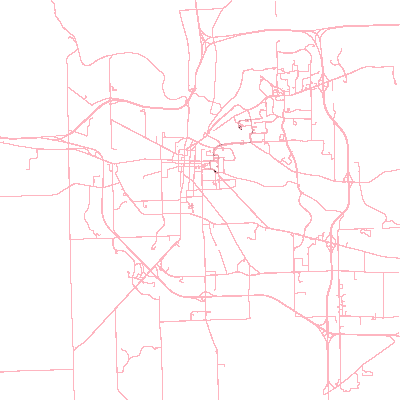

In [13]:
cvs = ds.Canvas(plot_width=width, plot_height=height, x_range=xrange, y_range=yrange)
pts = cvs.points(df, 'x', 'y', ds.count('Gentime'))
img = tf.interpolate(pts, low="lightpink", high='black', how='linear')
img

In [14]:
#df['Gentime'].plot(kind='hist', bins=24, color=(0.4,0.3,0.8), alpha=0.2)

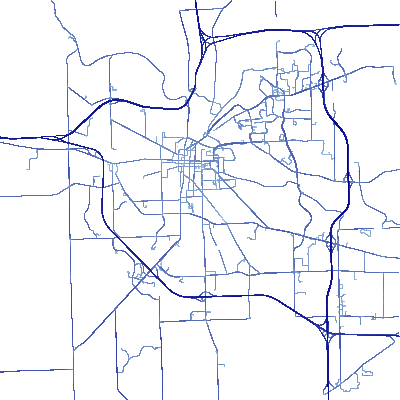

In [15]:
pts = cvs.points(df, 'x', 'y', ds.max('mph'))
img = tf.interpolate(pts, low="lightblue", high='darkblue', how='linear')
img

In [16]:
#df['mph'].plot.hist(bins=20, color=(0.5,0,0.5), alpha=0.5)

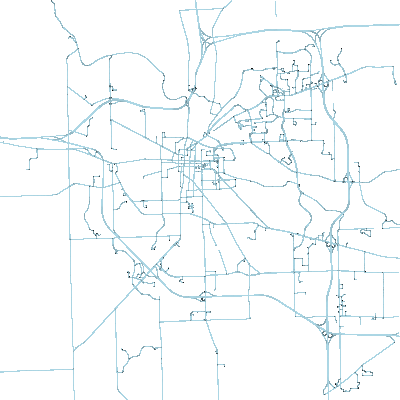

In [17]:
pts = cvs.points(df, 'x', 'y', ds.mean('Yawrate'))
img = tf.interpolate(pts, low='lightblue', high='black', how='linear')
img

In [18]:
#df['Yawrate'].plot.hist(color=(1,0,0), alpha=0.5)

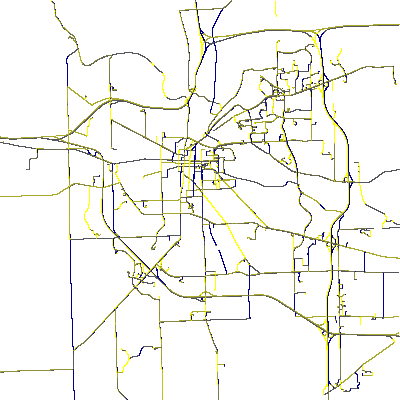

In [19]:
pts = cvs.points(df, 'x', 'y', ds.mean('Direction'))
img = tf.interpolate(pts, low="yellow", high='darkblue', how='linear')
img

In [20]:
#df['Direction'].plot.hist(color=(1,1,0), alpha=1)

### Plotting Multiple Layers

You can combine images together, layering images onto one another using the transfer function `stack` method.

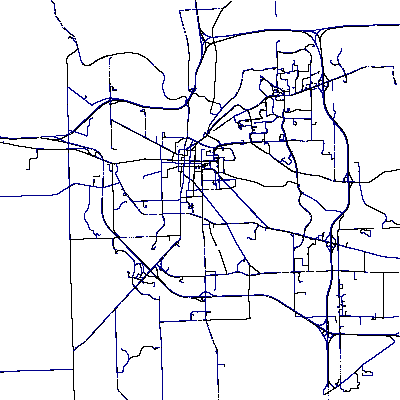

In [21]:
def merge_images(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    pts = cvs.points(df, 'x', 'y', ds.mean('Direction'))
    low = tf.interpolate(pts < 0, "lightblue", 'darkblue', how='linear')
    high = tf.interpolate(pts > 0, "yellow", 'black', how='linear')
    return tf.stack(high,low) # order of layers

merge_images(xrange,yrange,width,height)

### Datashader Interactive Plot

Datashader combined with the Bokeh interactive plot. Allows you to pan and zoom in on the image.  
1. For a single image and it will just zoom in on the image
2. More multiple images, it will re-draw a new image

In [22]:
def create_image(xrange, yrange, w=width, h=height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=xrange, y_range=yrange)
    agg = cvs.points(df, 'x', 'y', ds.mean('Heading'))
    img = tf.interpolate(agg, low="yellow", high='darkblue', how='linear')
    img2= img.copy()
    return tf.stack(img2, img)

p = base_plot()
InteractiveImage(p, create_image)

In [23]:
p2 = base_plot()
InteractiveImage(p2, merge_images)

### Add Background Web Tiles to Geospatial Data

Choose a web tile provider using the `WMTSTileSource` class and `add_tile` method. You can choose any provider like OpenStreetMaps, Esri, Mapbox, etc. Here we use the STAMEN watercolor web tiles.

In [26]:
tile_options = dict()
tile_options['url'] = 'http://tile.stamen.com/watercolor/{z}/{x}/{y}.png'
tile_source = WMTSTileSource(**tile_options)

p = base_plot()
p.add_tile(tile_source)
InteractiveImage(p, merge_images)

## References

References are bare bones since this is a brand new module (version 0.1.0).  
http://datashader.readthedocs.org/en/latest/  
https://media.readthedocs.org/pdf/datashader/latest/datashader.pdf

## Software Version for Creating this Jupyter Notebook

In [25]:
# you only need to do the following line once on your machine
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information pandas, numpy, bokeh, datashader

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.3
OS Windows 7 6.1.7601 SP1
pandas 0.18.1
numpy 1.10.4
bokeh 0.11.1
datashader 0.1.0
Fri Jul 15 16:40:34 2016 Eastern Daylight Time